<a href="https://www.kaggle.com/code/dascient/uacp-defining-powellscore-veracity-variables?scriptVersionId=138603780" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# UACP - Defining PowellScore & Veracity Variables

## [NLP - Sentiment Intensity Analyzer](https://github.com/cjhutto/vaderSentiment) Against Reporting Comments

### In collaboration with The Scientific Coalition for UAP Studies (SCU)[ExploreSCU.org].
​
Here we isolate only pertinent variables from the original dataset. For the sake of computational efficiency, we only use 500 samples from the reports. We've also decided to leave open most of the code cells below; enabling transparency on foundation of both variables. 

In [30]:
# for the sake of expeditious analysis
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from geopandas import GeoDataFrame
import matplotlib.colors as colors
import seaborn as sns
import random as r

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        #print('Files loaded.')
        
pd.set_option('display.max_colwidth', None)

# loading first nuforc dataframe
og_df1 = pd.read_csv('/kaggle/input/ufo-sightings/ufos.csv',header=0)
df = og_df1.dropna().copy()
og_df2 = pd.read_csv('/kaggle/input/d/NUFORC/ufo-sightings/scrubbed.csv',header=0)
df2 = og_df2.dropna().copy()

#############################################
# sanitize
# drop some columns, for now
df = df.drop(columns=['datetime','duration (hours/min)'])

# date posted deemed to be easily conveible to timestamp values, so i'm gonna work with that for now.
df['date posted'] = df['date posted'].astype('datetime64[ns]')


# length of comments
df['comment_length'] = [len(str(v[0:500])) for i,v in df.comments.items()]


# convert seconds to minutes
df["duration (minutes)"] = [int(v)/60 for i,v in df["duration (seconds)"].items()]


# creating Geo Point column for sopecial use below
df['Geo Point'] = df.apply(lambda x:'%s, %s' % (x['latitude'],x['longitude']),axis=1)


# let's create subsets of our 80,000 here: 
# we can implement conditionals, remove/analyze outliers, 
# & will enable for back referencing when starting to run 
# robust AI-ML modeling that would otherwise take much longer to run.

# let's create subsets from the main dataframe/reporting-data w/ respect to duration of observations
df_under100 = df[df["duration (minutes)"]<100]
df_under60 = df[df["duration (minutes)"]<60]

# random binary column for future AI-ML modeling.
a=['balloon','spacejunk','sensor_malfunction','undentified','anomalous']     
df['verified'] = pd.Series(r.choices(a,k=len(df),weights=(50, 40, 30, 20, 10)),index=df.index)

# shape-focused
circles = df[df['shape'] == 'circle']
spheres = df[df['shape'] == 'sphere']
lights = df[df['shape'] == 'light']
teardrops = df[df['shape'] == 'teardrop']

# year-month
df['year_month'] = df['date posted'].dt.to_period('M')

# ca_oval
ca_oval = df[df.state=='ca'].reset_index(drop=True)
ca_oval = ca_oval[ca_oval['shape']=='oval']


# show
print("\nOriginal dataset(s).")
print(f"\nReports: {len(df)} non-null dataframe.")
print("\nMatrix:",df.shape[0],"rows,",df.shape[1],"columns")
df = df.sort_values('date posted',ascending=True).reset_index(drop=True)
df.tail(11).reset_index(drop=True).style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'}).set_properties(**{'text-align': 'left'})

/kaggle/input/ufo-sightings/ufos.csv
/kaggle/input/d/NUFORC/ufo-sightings/complete.csv
/kaggle/input/d/NUFORC/ufo-sightings/scrubbed.csv

Original dataset(s).

Reports: 66516 non-null dataframe.

Matrix: 66516 rows, 14 columns


,city,state,country,shape,duration (seconds),comments,date posted,latitude,longitude,comment_length,duration (minutes),Geo Point,verified,year_month
0,henderson,nv,us,fireball,20.000000,"Very Strange Red Sphere Over Henderson, Nevada.",2014-05-08 00:00:00,36.039722,-114.981111,50,0.333333,"36.0397222, -114.9811111",balloon,2014-05
1,waxhaw,nc,us,circle,60.000000,Bright orb that rapidly traveled west leaving a light trail and vanishing.,2014-05-08 00:00:00,34.924444,-80.743611,74,1.000000,"34.9244444, -80.7436111",sensor_malfunction,2014-05
2,mount hope (canada),on,ca,teardrop,2700.000000,"Shell shaped object twitching it's way up in the sky, same time every other night.",2014-05-08 00:00:00,43.140000,-79.900000,88,45.000000,"43.14, -79.9",balloon,2014-05
3,atkinson,nh,us,sphere,300.000000,Flashlight made UFO disappear,2014-05-08 00:00:00,42.838333,-71.147500,29,5.000000,"42.8383333, -71.1475",sensor_malfunction,2014-05
4,lombard,il,us,circle,20.000000,Bright red & yellow colored ball flying west to east in a straight line.,2014-05-08 00:00:00,41.880000,-88.007778,76,0.333333,"41.88, -88.0077778",undentified,2014-05
5,waxhaw,nc,us,circle,60.000000,Bright orb that dimmed & got smaller before vanishing in the sky.,2014-05-08 00:00:00,34.924444,-80.743611,69,1.000000,"34.9244444, -80.7436111",balloon,2014-05
6,hialeah,fl,us,light,120.000000,My wife stepped outside to get some laundry and she noticed a bright orange light hovering in the sky and called me to come out and see,2014-05-08 00:00:00,25.857222,-80.278333,135,2.000000,"25.8572222, -80.2783333",sensor_malfunction,2014-05
7,grayson,ga,us,sphere,20.000000,"On May 3 around 9 pm I was studying Mars with an outdoor telescope on a clear night when a perfectly round , bright light appeared Sout",2014-05-08 00:00:00,33.894167,-83.955833,138,0.333333,"33.8941667, -83.9558333",sensor_malfunction,2014-05
8,currie,nc,us,light,120.000000,Brilliantly Lit Flying Object With Reddish Orange Lights.,2014-05-08 00:00:00,34.462500,-78.101389,57,2.000000,"34.4625, -78.1013889",balloon,2014-05
9,kuna,id,us,circle,600.000000,"Bright Orange light(orbs) 1 multiplied to 8, Moving in all directions and weird patterns went on for 10 minutes until disappered. Loud",2014-05-08 00:00:00,43.491944,-116.419167,137,10.000000,"43.4919444, -116.4191667",spacejunk,2014-05


In [31]:
# https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
# https://github.com/cjhutto/vaderSentiment
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # create a list
    results = []
    results.append({"% Positive":sentiment_dict['pos'],
                    "% Negative":sentiment_dict['neg'],
                    "% Neutral":sentiment_dict['neu']
                   })
    results = pd.DataFrame(results)
    return results

# Apply to df['comments'] column.
def NLP_PowellScore(commentsColumns):
    
    # obtain each comment for 'comments' column
    eachComment = [eachComment for i,eachComment in commentsColumns.items()]
    eachComment = pd.Series(eachComment)
                               
    # vader.variables.PowellScore
    PowellPositive = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Positive"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellNegative = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Negative"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellNeutral = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Neutral"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    
    return PowellPositive,PowellNegative,PowellNeutral

### Sample of 500 reports sorted by Veracity

In [36]:
# defining Powell Scores by sentiment outputs: Positive, Negative, Neutral.

# let's only take a small sample - this will definitely take a few minutes, grab yourself some water...
robert = df.sample(500).copy()

robert["PowellPositive"] = NLP_PowellScore(robert['comments'])[0]
robert["PowellNegative"] = NLP_PowellScore(robert['comments'])[1]
robert["PowellNeutral"] = NLP_PowellScore(robert['comments'])[2]

# PowellScore 
robert["PowellScore"] = (robert["PowellPositive"]-robert["PowellNegative"])/robert["PowellNeutral"]

# veracity
robert["veracity"] = robert["PowellScore"]*robert["comment_length"] # can incorporate lexicon analyses in place of the latter multiple.

# veracity is still very much in progress. we are looking for ways forward to 
# better define them. although, it is important to note that "veracity" will 
# be variable that is subjective to the type of datasets.
columns = ['date posted','city','state','shape','comments','comment_length',\
        'latitude','longitude','PowellPositive',\
        'PowellNegative','PowellNeutral','PowellScore','veracity']

df1 = robert[columns].sort_values('veracity',ascending=False).reset_index(drop=True)
df1[df1['comment_length']>10].head(20)\
        .style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

,date posted,city,state,shape,comments,comment_length,latitude,longitude,PowellPositive,PowellNegative,PowellNeutral,PowellScore,veracity
0,2013-07-03 00:00:00,rocky hill,ct,fireball,"Looked like a kite with dots in each side and Sorta like a diamond with 5 dots 1 in middle and 1 the left right top and bottom, and 7",137,41.664722,-72.639722,0.308000,0.000000,0.692000,0.445087,60.976879
1,2012-01-24 00:00:00,league city,tx,sphere,"Two stationary, silent, super bright white spheres about 100-200 feet in the air.",87,29.507222,-95.094722,0.382000,0.000000,0.618000,0.618123,53.776699
2,2009-05-12 00:00:00,duarte,ca,flash,"It looked like a smashed diamond a parallagram if you will-the color of flash like a camera, during I got my cell phone it was gone.",136,34.139444,-117.976389,0.280000,0.000000,0.720000,0.388889,52.888889
3,2002-07-26 00:00:00,las cruces,nm,cylinder,Huge bright lime green Cylinder Shaped Object,45,32.312222,-106.777778,0.510000,0.000000,0.490000,1.040816,46.836735
4,2005-10-11 00:00:00,oak forest,il,light,"2 Bright Red lights above my house, then gain altitude before heading east very slowly",89,41.602778,-87.743889,0.344000,0.000000,0.656000,0.524390,46.670732
5,2005-11-03 00:00:00,montville,oh,cone,"Six coned like objects,with bright white lights floating in the Montville sky.",81,41.607222,-81.050556,0.351000,0.000000,0.649000,0.540832,43.807396
6,2003-09-04 00:00:00,monroe,wa,fireball,"Oval fireball, bright white and blue-green, with trailing tail, comes down swiftly at steep angle. (Nuforc Note: Meteor?)",132,47.855556,-121.969722,0.242000,0.000000,0.758000,0.319261,42.142480
7,2004-01-31 00:00:00,greensboro,nc,disk,Bright disc shaped object seen over the Greensboro airport during clear conditions in the early afternnoon with many airplanes visible,134,36.072500,-79.792222,0.234000,0.000000,0.766000,0.305483,40.934726
8,2005-05-24 00:00:00,wilmington,nc,light,Two bright lights came into view as we were sitting on our back porch. They appeared to be fairly far away - like bright stars. No soun,135,34.225556,-77.945000,0.255000,0.068000,0.677000,0.276219,37.289513
9,1999-01-28 00:00:00,panama city beach,fl,light,One light appeared over Gulf of Mexico. Looked about as bright as Venus at dusk. Became brighter. Then others appeared.,121,30.176389,-85.805556,0.234000,0.000000,0.766000,0.305483,36.963446


## Ovals seen between Imperial Beach & Blythe, California

In [37]:
# only ovals
ca_oval_162 = ca_oval.sort_values(['latitude','longitude'])
robert_ca_oval_162 = ca_oval_162
robert_ca_oval_162["PowellPositive"] = NLP_PowellScore(robert_ca_oval_162['comments'])[0]
robert_ca_oval_162["PowellNegative"] = NLP_PowellScore(robert_ca_oval_162['comments'])[1]
robert_ca_oval_162["PowellNeutral"] = NLP_PowellScore(robert_ca_oval_162['comments'])[2]

# PowellScore 
robert_ca_oval_162["PowellScore"] = (robert_ca_oval_162["PowellPositive"]-robert_ca_oval_162["PowellNegative"])/robert_ca_oval_162["PowellNeutral"]

# veracity
robert_ca_oval_162["veracity"] = robert_ca_oval_162["PowellScore"]*robert_ca_oval_162["comment_length"] # can incorporate lexicon analyses in place of the latter multiple.


df2 = robert_ca_oval_162[['date posted','city','state','shape','comments','comment_length','duration (minutes)',\
        'latitude','longitude','PowellPositive','PowellScore','veracity']].sort_values(['veracity'],ascending=False).reset_index(drop=True)
df2.head(50).style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

,date posted,city,state,shape,comments,comment_length,duration (minutes),latitude,longitude,PowellPositive,PowellScore,veracity
0,2006-03-11 00:00:00,ontario,ca,oval,"huge bright eliptical shaped object with multi colored lights flashing, like millions of sparkling diamonds",110,30.000000,34.063333,-117.650000,0.474000,0.901141,99.125475
1,2013-05-15 00:00:00,etiwanda,ca,oval,7 bright orange orb like object's,36,3.000000,34.126111,-117.522778,0.643000,1.801120,64.840336
2,2004-09-09 00:00:00,los angeles,ca,oval,One of the items was shaped like an eclipse. I was so impressed that I retained notes of these occurences. Both occured on the same e,135,23.000000,34.052222,-118.242778,0.282000,0.392758,53.022284
3,2011-03-10 00:00:00,oceanside,ca,oval,Brilliant flare like object into black craft with red light,59,5.000000,33.195833,-117.378611,0.441000,0.788909,46.545617
4,2008-10-31 00:00:00,thousand oaks,ca,oval,"Bright blue flare enters atmosphere, quickly shifts horizontal, gains altitude for 7 secs, blinks blue 24 times while descending fully",143,0.500000,34.170556,-118.836667,0.238000,0.312336,44.664042
5,2005-09-02 00:00:00,los angeles,ca,oval,I saw a UFO with a few other witnesses on Friday night the 10th but didn't have a chance to capture it on videotape. Luckily it came ba,138,45.000000,34.052222,-118.242778,0.240000,0.315789,43.578947
6,2010-02-14 00:00:00,leggett,ca,oval,Stationary object flashes pure bright white light. It was like it was taking pictures.,87,0.066667,39.865833,-123.713056,0.310000,0.449275,39.086957
7,2009-01-10 00:00:00,dublin,ca,oval,"Date: Nov 4, 2008 Time: 20:30 hours (Exact Time) Visibility: Clear night, unlimited vision Location: North bound I680 from Pleasanton",140,10.000000,37.702222,-121.934722,0.204000,0.256281,35.879397
8,2005-05-24 00:00:00,sage,ca,oval,Very bright like alumium when the sun shines on it and hovered in one place for about 45 seconds.,98,0.750000,33.581667,-116.931389,0.260000,0.351351,34.432432
9,1998-11-01 00:00:00,san marcos,ca,oval,"Friend and I were driving down the highway...moderate traffic. I noticed the aircraft first, it was hoovering over the freeway about 30",138,10.000000,33.143333,-117.165278,0.196000,0.243781,33.641791


## Powell Variables in 3D
This is a 3D-interactive chart that uses the date posted, veracity, & PowellScore variables. Colored by comments. Sized by comment_length.

By definition, these actually render 5-Dimensional charts, if one considers veracity & commenth lengths of reports as 'features of a situation'.

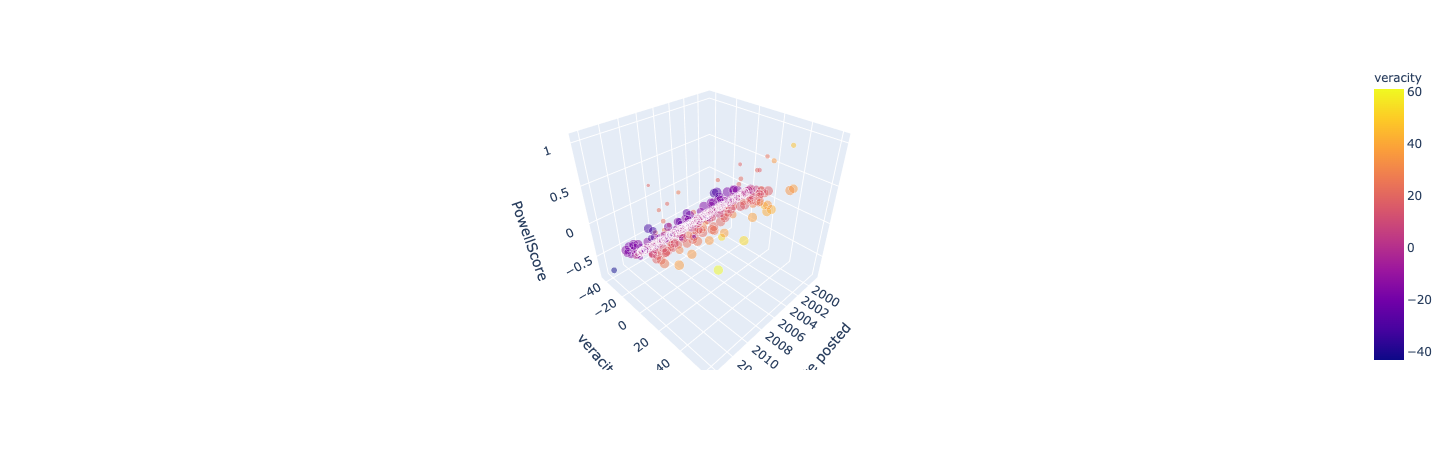

In [38]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(df1, x='date posted', y='veracity', z='PowellScore',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

### This one shows Date Posted vs PowellScore & PowellPositive Variables of California Oval reports.

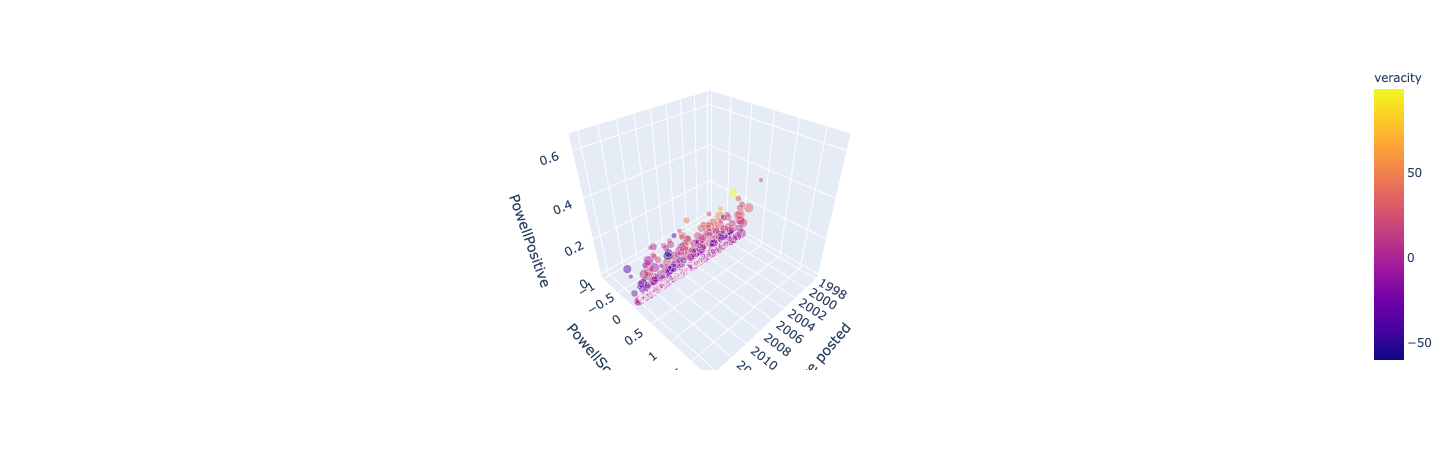

In [39]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(df2, x='date posted', y='PowellScore', z='PowellPositive',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

### Ovals seen between Imperial Beach & Blythe, California - Date Posted vs PowellNeutral vs PowellScore

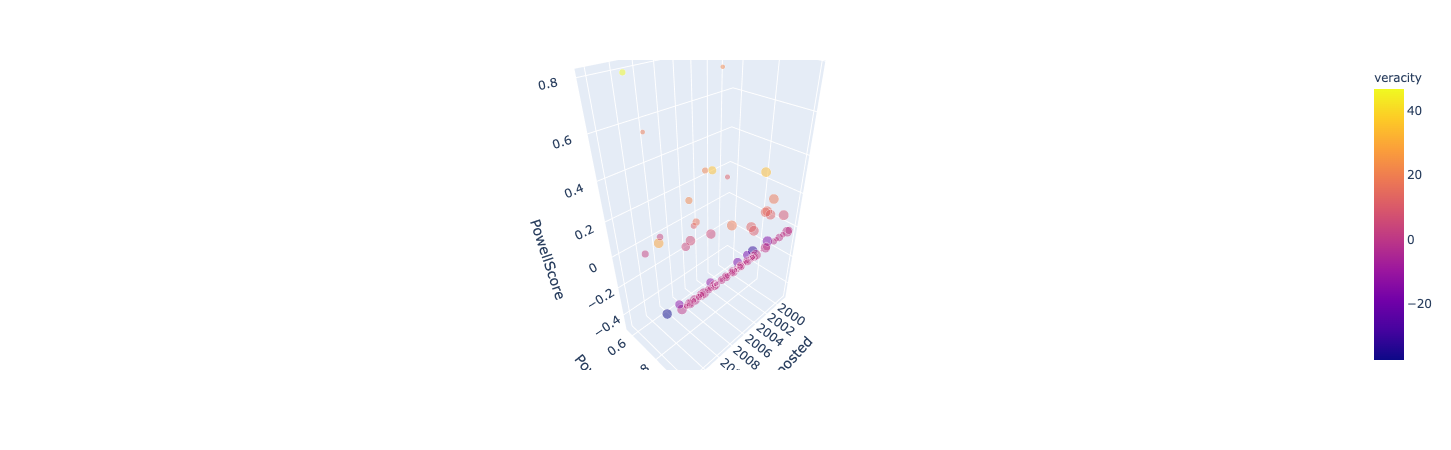

In [8]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(robert_ca_oval_162, x='date posted', y='PowellNeutral', z='PowellScore',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments','shape'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

These variables are still very much in progress & there currently is no process for defining them. Despite the disparate, disconnected, & wide range of skeptic/non-skeptic relational databases — we have managed to connect with organizations that promote open source — public repositories & most are willing to coordinate with one another in developing a UAP Reporting & Events Hub. Wherein all pertinent reports, sightings, measurements, & signatures are to be populated by various factors from multiple disciplines & technologies. We will do our best to coordinate with prominent key members of the UAP community in order to contribute to building out a “standardized” reporting mechanism in an intelligible & non-duplicative fashion. We are looking for ways forward in getting access to real-time, current reports.

The goal would be to create something similar to an Order of Battle, so that reports at specific times & locations can be compared to past reports to augment credibility determination, as well as eventually be compared to known events that may explain them. Once those explanations are vetted, reports would be coded by likelihood of mundane vs anomalous, which would aid in the processing of similar events in the future.

In addition, we have already begun looking for trends over time, such as the time of day when reported events take place, & the type of object reported over the decades. The latter can be observed in the “Shapes by Share of Reports” chart, which provides indications of confirmation bias in observed behavior.

Finally, big data analysis (alongside robust AI|ML|DS modeling techniques) could also provide insight into the development of improved collection & reporting processes, which currently appear to be undefined, improving the quality of the data we receive. — K. Kolbe.

# Different NLP Methods

# DaS-VADER Sentiment Analyzer

Here, we intend to begin focusing on the lexicon analysis of each somment submission. We will have to tinker with [VADER's Lexicon .txt file](https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt) in order to build out a more scientific vs emotional syntax analyzer. Comments & Advice are all welcome. 

In [9]:
df[['comments']].sample(30).style.set_properties(**{'text-align': 'left'})

,comments
23553,Fireball seen in sky over SE Reno.
51013,"5 orange red lights moving over Layton, Utah"
53025,We were at Disneyland walking around and I noticed a round orange sphere/UFO moving very slow in the sky. It was an odd orange color w
25270,"Triangle or boomerang shaped silent craft over Butte Montana March 2, 2006 19:15 local"
41307,Observed a kite-shaped asterism silently moving like a low flying plane.
44064,A low flying cylinder shaped obect with a propeller fan looking device at the end about 150 above ground.
32607,"Saw a big triangle hovering silently over busy state rte. and then after It ""watched"" traffic for a bit, it sped off to the southwest F"
56355,Fleet of red UFO's emerging from Mt. Rainier.
22083,"Brightly lit, digital-moving flying fish-shaped object with a crest of white-yellow fire emitting from its tail."
3588,"I vehemently did not believe the sightings of 1974 Spring in Birmingham, seems they appeared purposely so that I would believe, 3 craft"


In [10]:
# lets split up every word from every column & frame that in itself, call it "words"
a = [v.split(' ') for i,v in df.comments.items()]
flatlist=[]
for sublist in a:
    for element in sublist:
        flatlist.append(element)
comments = pd.DataFrame(flatlist, columns=['words'])
comments

,words
0,Family
1,traveling
2,home
3,along
4,a
...,...
944552,lights
944553,seen
944554,over
944555,Parkersburg&#44


In [ ]:
pd.set_option('display.max_rows', None)

comments.words.value_counts().head(10000)

<Axes: >

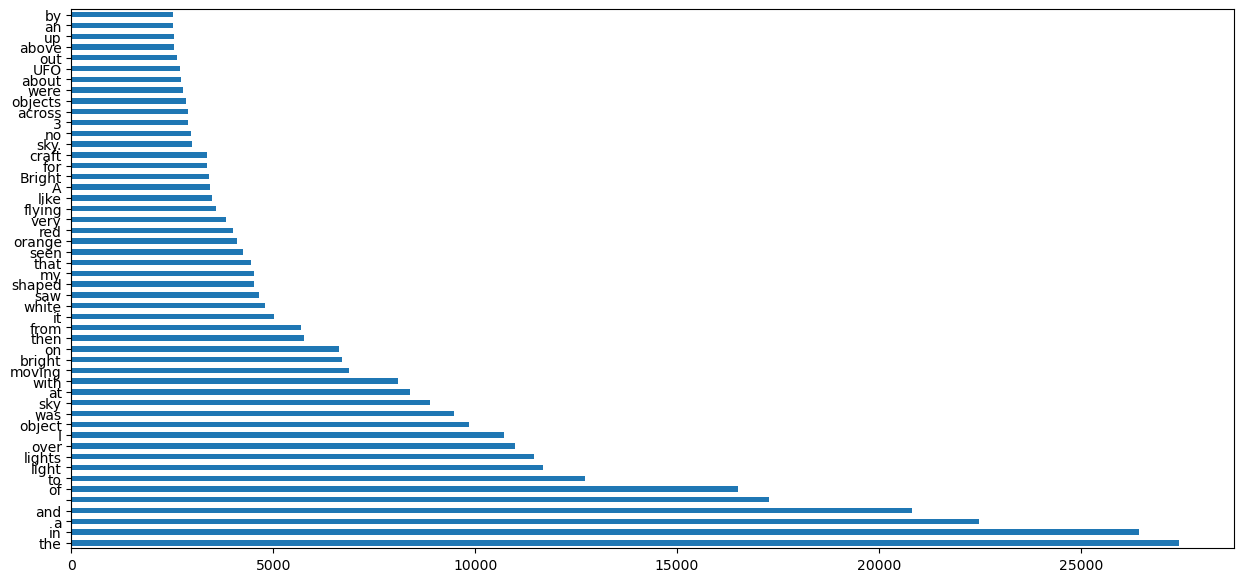

In [12]:
comments.words.value_counts().head(50).plot(kind='barh',figsize=(15,7))

In [ ]:
# billy-boy!
# isolate only "adjectives, nouns, verbs, & adverbs"


# Visual Insights

## Word Clouds
### All 500 samples.

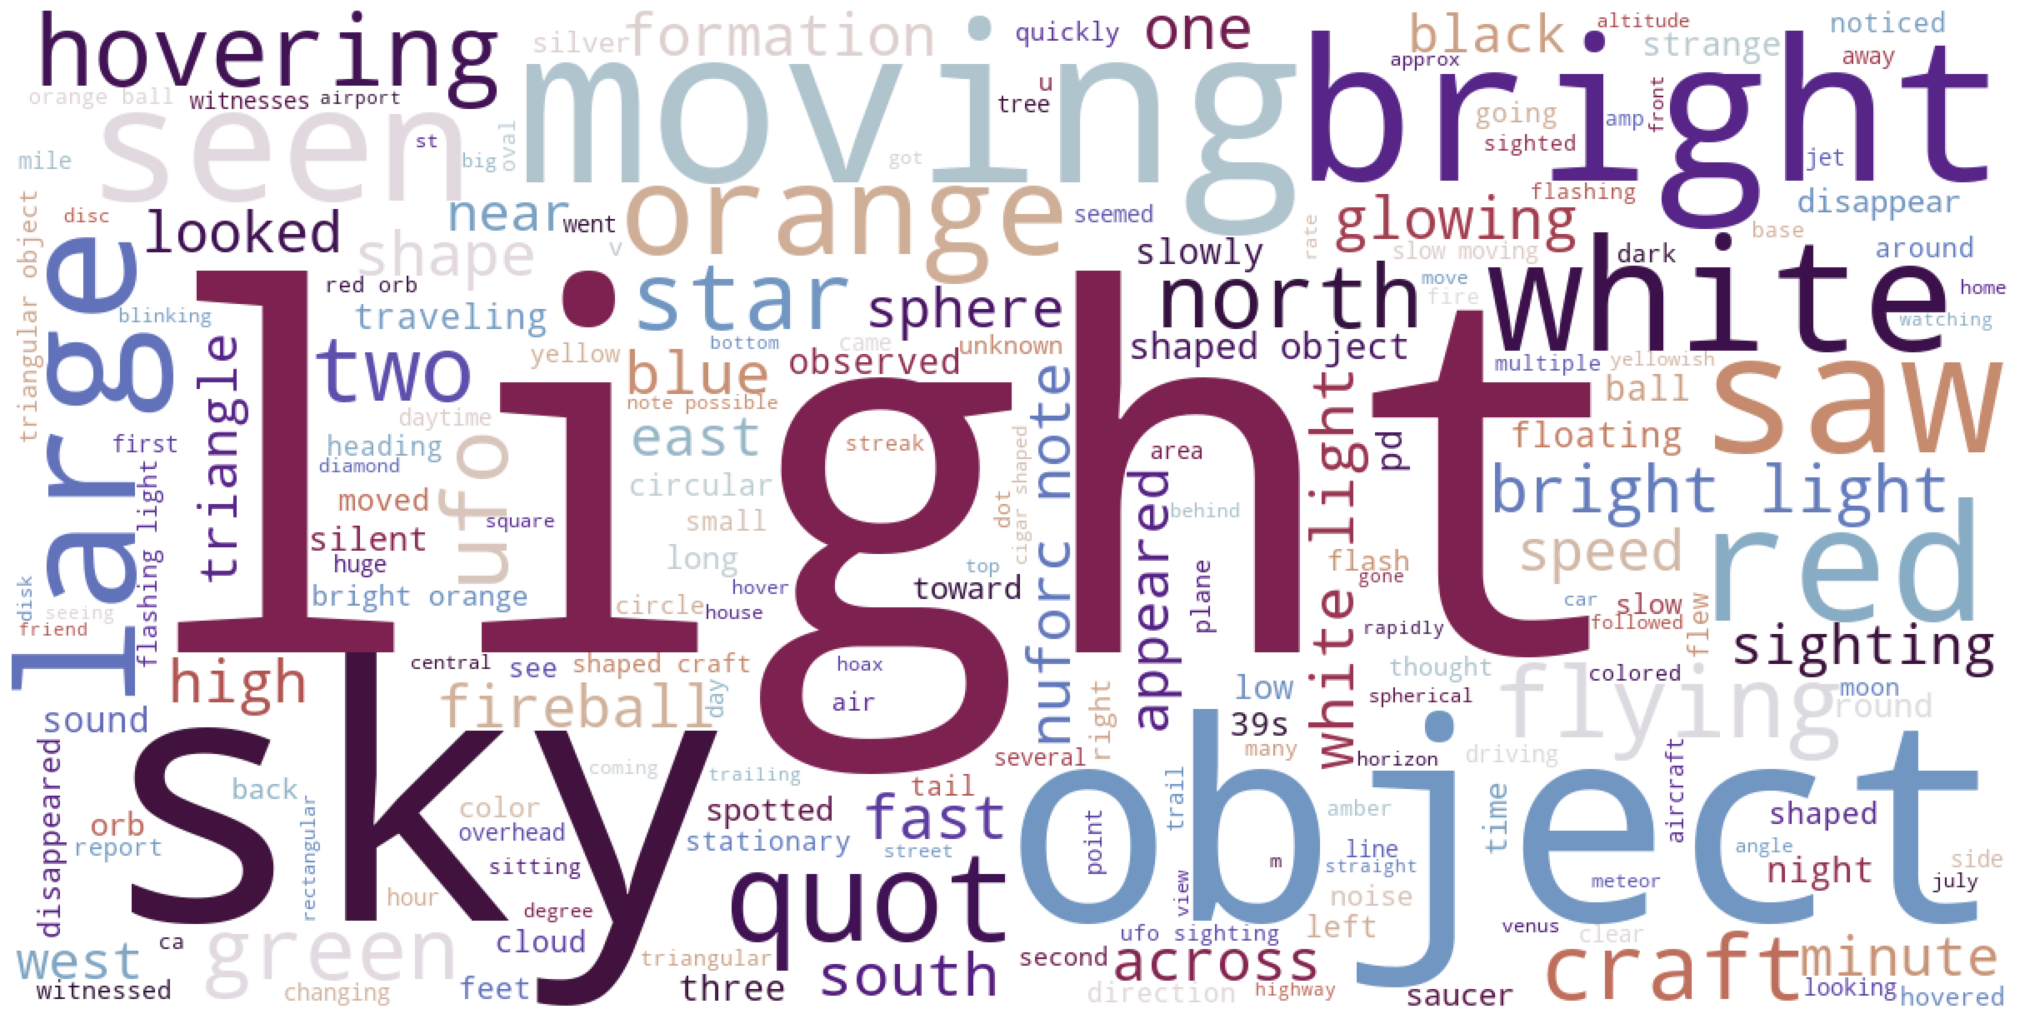

In [40]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# in the clouds
# 500 samples 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df1.comments:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 7,
                colormap='twilight').generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize=(25,10), facecolor='None')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### California Ovals 

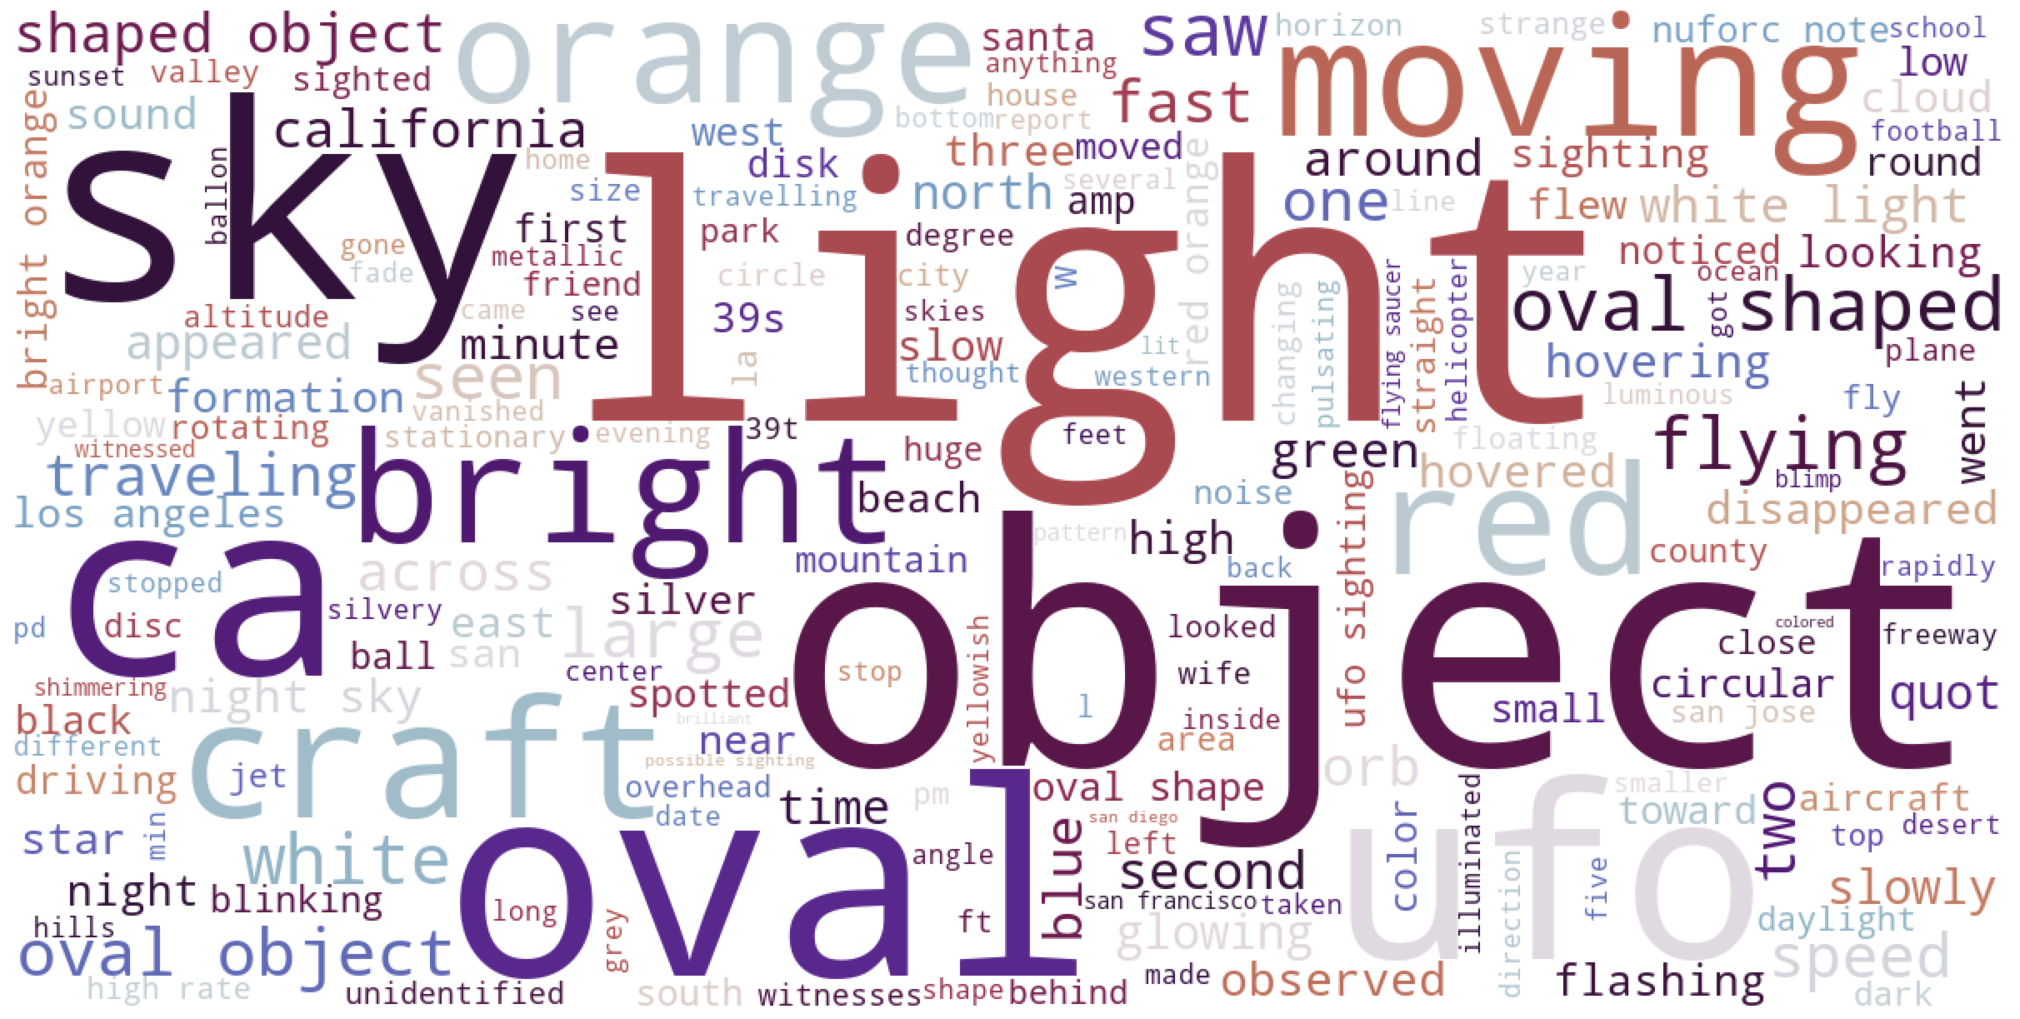

In [41]:
# in the clouds
# california ovals
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df2.comments:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 7,
                colormap='twilight').generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize=(25,10), facecolor='None')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Top Veracity Comments

In [47]:
df1.reset_index(drop=True).set_index('veracity').comments

veracity
 60.976879                      Looked like a kite with dots in each side and Sorta like a diamond with 5 dots 1 in middle and 1 the left right top and bottom&#44  and 7
 53.776699                                                                        Two stationary&#44 silent&#44 super bright white spheres about 100-200 feet in the air.
 52.888889                       It looked like a smashed diamond a parallagram if you will-the color of flash like a camera&#44  during I got my cell phone it was gone.
 46.836735                                                                                                                  Huge bright lime green Cylinder Shaped Object
 46.670732                                                                      2 Bright Red lights above my house&#44 then gain altitude before heading east very slowly
 43.807396                                                                              Six coned like objects&#44with bright white lights fl

### California Ovals Comments

In [48]:
df2.set_index('veracity').comments

veracity
 99.125475                                            huge bright eliptical shaped object with multi colored lights flashing&#44 like millions of sparkling diamonds
 64.840336                                                                                                                      7 bright orange orb like object&#39s
 53.022284                   One of the items was shaped like an eclipse.  I was so impressed that I retained notes of these occurences.  Both occured on the same e
 46.545617                                                                                               Brilliant flare like object into black craft with red light
 44.664042           Bright blue flare enters atmosphere&#44 quickly shifts horizontal&#44 gains altitude for 7 secs&#44 blinks blue 24 times while descending fully
 43.578947                I saw a UFO with a few other witnesses on Friday night the 10th but didn&#39t have a chance to capture it on videotape. Luckily it came ba
 